# 

First, import the necessary package. If you get an error here, make sure your kernel (upper right) is set to PlantCV, and that you have PlantCV installed. 

In [58]:
import cv2
from plantcv import plantcv as pcv
from plantcv.parallel import WorkflowInputs

Next, import a sample image. Your images need to be on the server. Remember, always keep your raw images separate from your newly processed images! You will need to change the path to your image, and also if you want specific output folders and directories. 

In [59]:
from tkinter import Tk
from tkinter.filedialog import askopenfilename

def select_images():
    """Function to open a file dialog and return selected image paths."""
    Tk().withdraw()
    image_path = askopenfilename(title="Select an image for segmentation")
    return image_path

# Use the function to select images
selected_images = select_images()

# Input/output options with selected images
args = WorkflowInputs(
    images= [selected_images],  # Use the selected images
    names="image",
    result="example_results_oneimage_file.csv",
    outdir=".",
    writeimg=False,
    debug="plot"
    )

In [60]:
# Set debug to the global parameter 
pcv.params.debug = args.debug
# Change display settings
pcv.params.dpi = 100
pcv.params.text_size = 20
pcv.params.text_thickness = 20

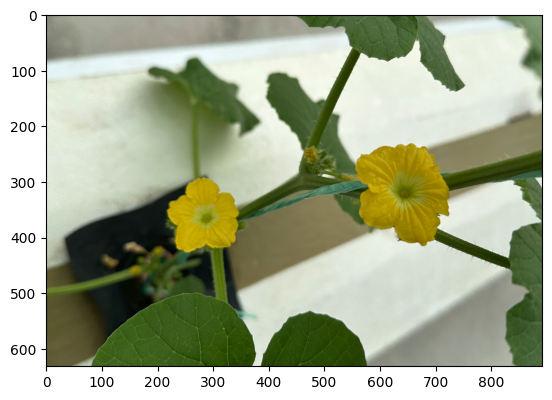

In [61]:
# Read in your image, which is based on the path you put above

# Inputs:
#   filename - Image file to be read in 
#   mode - Return mode of image; either 'native' (default), 'rgb', 'gray', or 'csv' 
img, path, filename = pcv.readimage(filename=args.image)

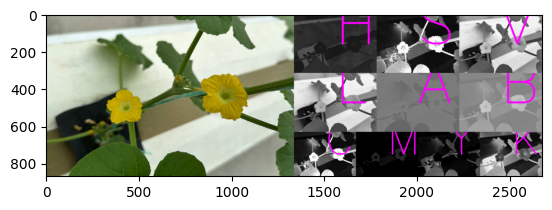

In [62]:
# Crop image if necessary. This is optional. 
colorspace_img = pcv.visualize.colorspaces(rgb_img=img)

Visualize the colors in the image.

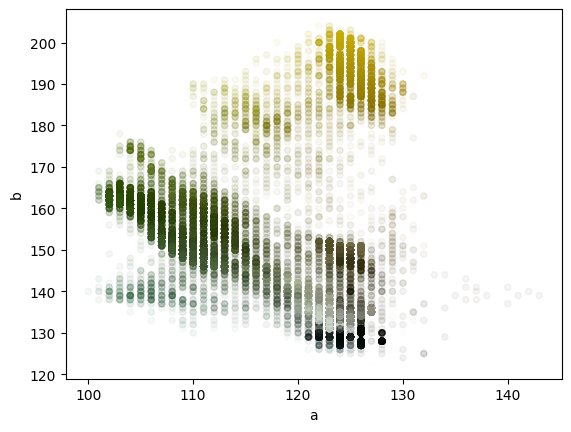

In [63]:
#If you want to save your color corrected image, do so here. Do NOT save over your raw image. 
#We are saving as a temporary image here becasue we want to use it for thresholding. 
pcv.print_image(img, filename = "./color_corrected_img_temp.png")
color_scatter = pcv.visualize.pixel_scatter_plot(paths_to_imgs = ["./color_corrected_img_temp.png"] , x_channel = "a", y_channel ="b" )

Method 1 to threshold

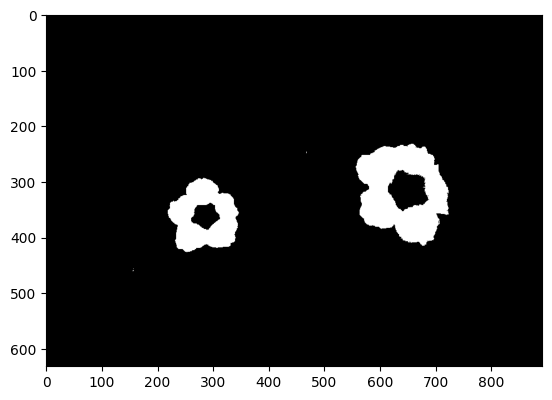

In [80]:
#Threshold your image by choosing points in the plot that will separate the green plant pixels from everything else. 
# It will draw a line between your two points and take every pixel "above" (if set to true). Do you get all of the plant?
thresh1 = pcv.threshold.dual_channels(rgb_img = img, x_channel = "a", y_channel = "b", points = [(120,190),(130,170)], above=True)

Method 2 to threshold

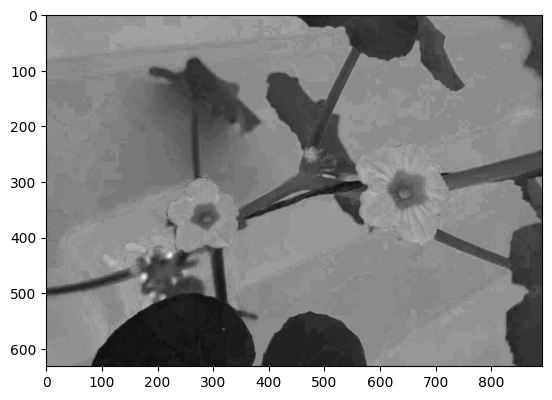

alt.Chart(...)

In [77]:
# Convert image from RGB color space to LAB and keep only the green-magenta channel 
a = pcv.rgb2gray_lab(rgb_img=img, channel='a')
hist_figure1 = pcv.visualize.histogram(a, bins=50)

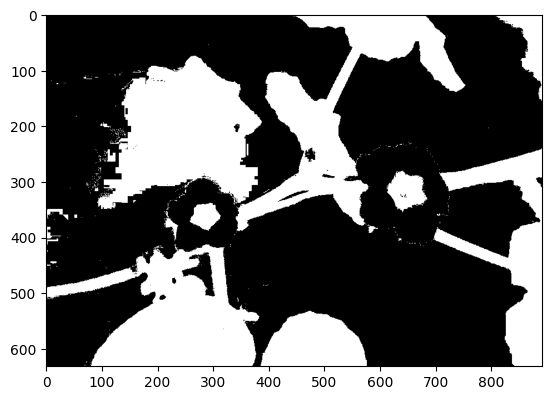

In [79]:
# Set a binary threshold on the image 
thresh1 = pcv.threshold.binary(gray_img=a, threshold=120, object_type='dark')

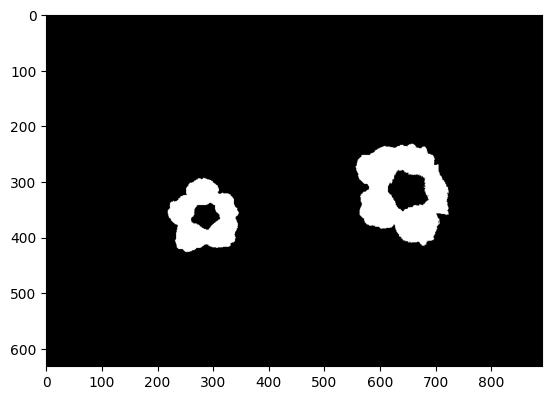

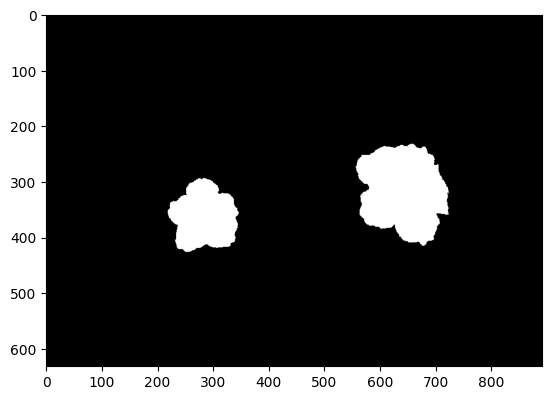

In [81]:
# Fill in small objects if the above threshold looks like there are "holes" in the leaves
a_fill_image = pcv.fill(bin_img=thresh1, size=50)
a_fill_image = pcv.fill_holes(a_fill_image)
#pcv.plot_image(a_fill_image)

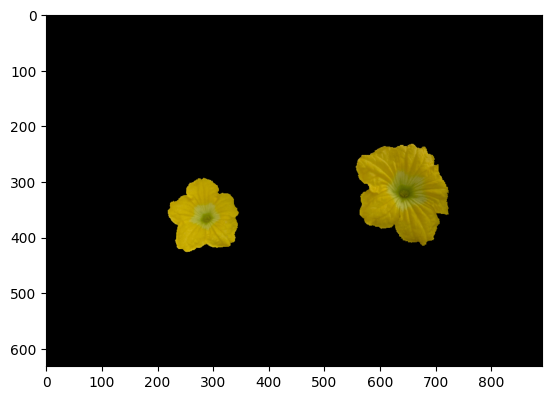

In [82]:
# Apply binary mask to original cropped image
masked = pcv.apply_mask(img=img, mask=a_fill_image, mask_color="black")

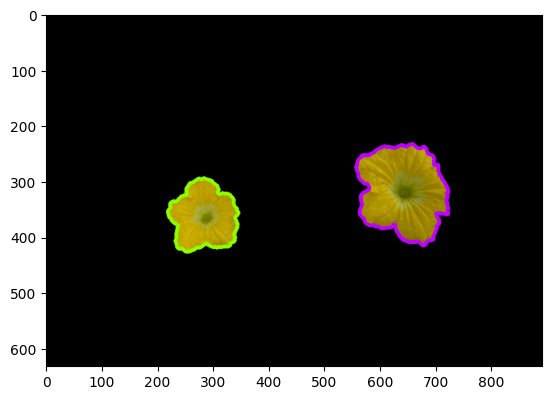

In [98]:
# Apply Watershed Segmentation Function

# mask can be : thresholded image, mask, or binary image
analysis_images = pcv.watershed_segmentation(rgb_img=masked, mask=a_fill_image, distance=200, label="default")

In [101]:
def blob_analysis(binary_image):
    # Find contours
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Number of blobs
    count = len(contours)
    
    # Iterate through each contour to calculate properties
    blob_properties = []
    for contour in contours:
        # Calculate area
        area = cv2.contourArea(contour)
        
        # Calculate bounding box (length and width)
        x, y, width, height = cv2.boundingRect(contour)
        
        # Calculate perimeter (circumference)
        circumference = cv2.arcLength(contour, True)
        
        # Store the properties
        blob_properties.append({
            'Area': area,
            'Bounding Box': (width, height),
            'Circumference': circumference
        })
    
    return count, blob_properties

# Load the binary image
binary_image = a_fill_image

# Ensure the image is binary
_, binary_image = cv2.threshold(binary_image, 127, 255, cv2.THRESH_BINARY)

# Perform blob analysis
count, properties = blob_analysis(binary_image)

# Print results
print(f'Number of blobs: {count}')
for i, prop in enumerate(properties):
    print(f'Blob {i+1}:')
    print(f"  Area: {prop['Area']}")
    print(f"  Bounding Box (Width, Height): {prop['Bounding Box']}")
    print(f"  Circumference: {prop['Circumference']}")


Number of blobs: 2
Blob 1:
  Area: 11763.0
  Bounding Box (Width, Height): (128, 134)
  Circumference: 487.445738196373
Blob 2:
  Area: 21760.0
  Bounding Box (Width, Height): (167, 183)
  Circumference: 711.2691133022308


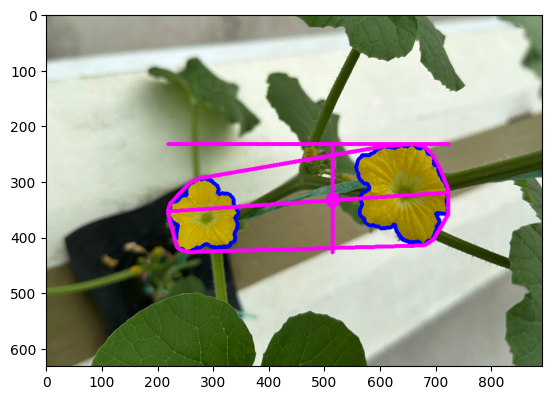

In [100]:
############### Analysis ################ 
  
# Find shape properties, data gets stored to an Outputs class automatically

# Inputs:
#   img - RGB or grayscale image data 
#   labeled_mask - the mask of each individual object, set by the create_labels function. 
#   n_labels - the number of objects, set by the create_labels function. 

analysis_image = pcv.analyze.size(img=img, labeled_mask=a_fill_image)


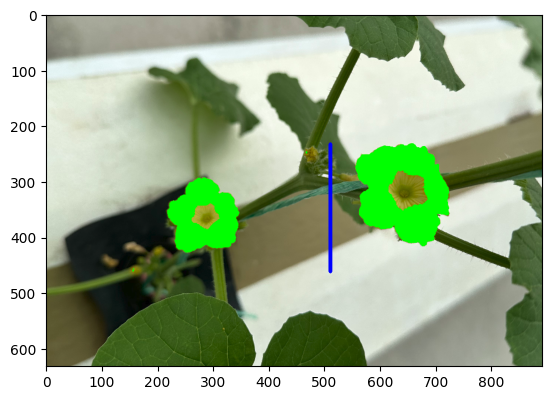

In [85]:
# Shape properties relative to user boundary line (optional). This is useful if your plant is hanging below the pot and you want height from the top of the pot.
# Set your line_position by finding the x-value at the top of the pot, hover your cursor to get that value

# Inputs:
#   img - RGB or grayscale image data 
#   obj - Single or grouped contour object 
#   mask - Binary mask of selected contours 
#   line_position - Position of boundary line (a value of 0 would draw a line 
#                   through the bottom of the image) 
#   label - Optional label parameter, modifies the variable name of observations recorded. (default `label="default"`)filled_img = pcv.morphology.fill_segments(mask=cropped_mask, objects=edge_objects)

boundary_image = pcv.analyze.bound_horizontal(img=img,labeled_mask=thresh1, 
                                               line_position=2380, label="default")


In [88]:
# Determine color properties: Histograms, Color Slices and Pseudocolored Images, output color analyzed images (optional)

# Inputs:
#   rgb_img - RGB image data
#   mask - Binary mask of selected contours 
#   colorspaces - 'all' (default), 'rgb', 'lab', or 'hsv'
#                 This is the data to be printed to the SVG histogram file  
#   label - Optional label parameter, modifies the variable name of observations recorded. (default `label="default"`)

color_histogram = pcv.analyze.color(rgb_img=img, labeled_mask=kept_mask, colorspaces='all', label="default")


NameError: name 'kept_mask' is not defined

In [ ]:
# The save results function will take the measurements stored when running any PlantCV analysis functions, format, 
# and print an output text file for data analysis. The Outputs class stores data whenever any of the following functions
# are ran: analyze_bound_horizontal, analyze_bound_vertical, analyze_color, analyze_nir_intensity, analyze_object, 
# fluor_fvfm, report_size_marker_area, watershed. If no functions have been run, it will print an empty text file 

#This saves results for one image, and each image is saved individually if you run another image (it will overwrite the last one)
pcv.outputs.save_results(filename=args.result)
